<a href="https://colab.research.google.com/github/sowole-aims/agric-aid/blob/main/corn_maize_disease_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Import necessary libraries

In [ ]:
import numpy as np
import pandas as pd
import os, glob
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt
import seaborn as sns

#### Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Define file path and obtain list of file paths and labels

In [ ]:
file_path = '/content/drive/MyDrive/data'
filepaths = list(glob.glob(file_path + '/**/*.*'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

#### Create a DataFrame for the data

In [ ]:
filepath_series = pd.Series(filepaths, name='Filepath').astype(str)
labels_series = pd.Series(labels, name='Label')
data = pd.concat([filepath_series, labels_series], axis=1)
data = data.sample(frac=1).reset_index(drop=True)  # Shuffle the data
data.head(5)

,Filepath,Label
0,/content/drive/MyDrive/data/Common_Rust/Corn_C...,Common_Rust
1,/content/drive/MyDrive/data/Common_Rust/Corn_C...,Common_Rust
2,/content/drive/MyDrive/data/Gray_Leaf_Spot/Cor...,Gray_Leaf_Spot
3,/content/drive/MyDrive/data/Common_Rust/Corn_C...,Common_Rust
4,/content/drive/MyDrive/data/Common_Rust/Corn_C...,Common_Rust


#### Display distribution of labels

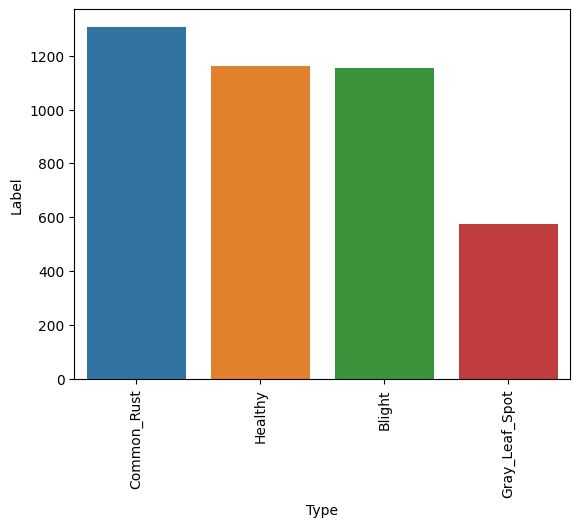

In [ ]:
counts = data.Label.value_counts()
sns.barplot(x=counts.index, y=counts)
plt.xlabel('Type')
plt.xticks(rotation=90);

####  Define image and batch sizes

In [ ]:
IMAGE_SIZE = (256,256)
BATCH_SIZE = 32

#### Load the dataset

In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    file_path,
    shuffle=True,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)

Found 4198 files belonging to 4 classes.


#### Get class names and dataset length

In [ ]:
class_names = dataset.class_names
class_names

['Blight', 'Common_Rust', 'Gray_Leaf_Spot', 'Healthy']

In [ ]:
len(dataset)

132

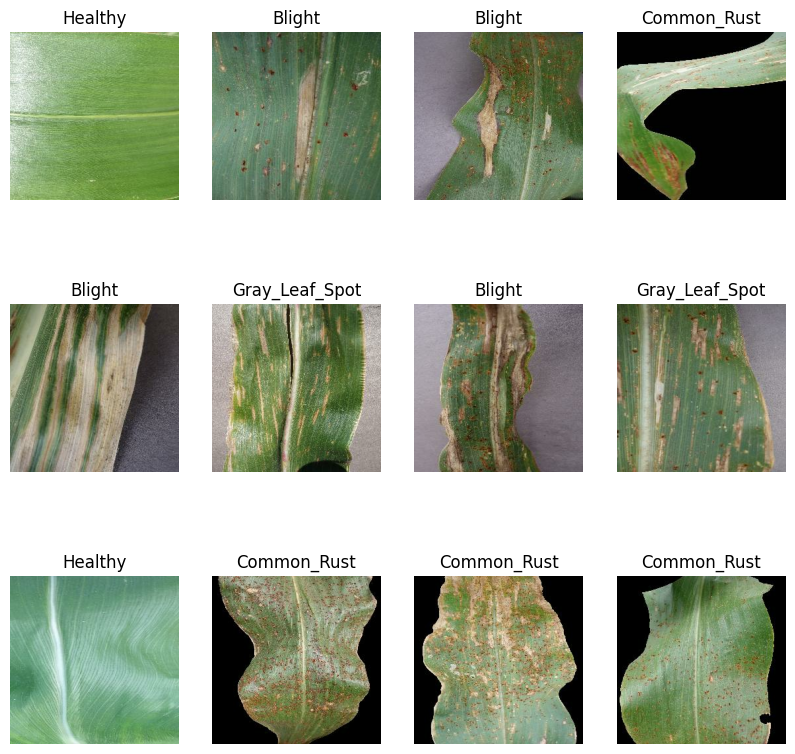

In [ ]:
plt.figure(figsize=(10,10))
for image_batch , label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])
        plt.axis('off')

#### Data Agumentation

In [ ]:
# Split dataset into training, validation and test sets
def get_dataset(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size,seed=8)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)

    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds,val_ds,test_ds

In [ ]:
train_ds,val_ds,test_ds = get_dataset(dataset)

In [ ]:
print("Length of Training Dataset is",len(train_ds))
print("\nLength of Validation Dataset is",len(val_ds))
print("\nLength of Testing Dataset is",len(test_ds))

Length of Training Dataset is 105

Length of Validation Dataset is 13

Length of Testing Dataset is 14


In [ ]:
# Cache and prefetch the datasets for better performance
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
# Define image preprocessing layers
resize_and_rescale = tf.keras.Sequential([
layers.experimental.preprocessing.Resizing(256,256),
layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [ ]:
# Define data augmentation layers
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

#### Model Building

In [ ]:
# Define the model architecture
n_classes = 4
input_shape = (BATCH_SIZE,256,256,3)
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3),activation ='relu',input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size = (3,3),activation ='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size = (3,3),activation ='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size = (3,3),activation ='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size = (3,3),activation ='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(n_classes,activation='softmax'),

])
model.build(input_shape=input_shape)

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                 

In [ ]:
# Compile the model
model.compile(
optimizer='adam',
loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
metrics=['accuracy']
)

#### Model Fitting

In [ ]:
# Train the model
history = model.fit(
train_ds,
epochs=40,
batch_size=BATCH_SIZE,
verbose=1,
validation_data=val_ds)

Epoch 1/40
105/105 [==============================] - 44s 170ms/step - loss: 0.7359 - accuracy: 0.6953 - val_loss: 0.4806 - val_accuracy: 0.8197
Epoch 2/40
105/105 [==============================] - 6s 58ms/step - loss: 0.4499 - accuracy: 0.8218 - val_loss: 0.3587 - val_accuracy: 0.8462
Epoch 3/40
105/105 [==============================] - 6s 57ms/step - loss: 0.4061 - accuracy: 0.8311 - val_loss: 0.3320 - val_accuracy: 0.8702
Epoch 4/40
105/105 [==============================] - 6s 57ms/step - loss: 0.3740 - accuracy: 0.8545 - val_loss: 0.3421 - val_accuracy: 0.8654
Epoch 5/40
105/105 [==============================] - 6s 59ms/step - loss: 0.3969 - accuracy: 0.8416 - val_loss: 0.3066 - val_accuracy: 0.8654
Epoch 6/40
105/105 [==============================] - 6s 59ms/step - loss: 0.3577 - accuracy: 0.8524 - val_loss: 0.3186 - val_accuracy: 0.8654
Epoch 7/40
105/105 [==============================] - 6s 58ms/step - loss: 0.3327 - accuracy: 0.8587 - val_loss: 0.2543 - val_accuracy: 0.89

In [ ]:
# Evaluate the model on the test set
scores = model.evaluate(test_ds)

14/14 [==============================] - 11s 27ms/step - loss: 0.2026 - accuracy: 0.9353


In [ ]:
history.params

{'verbose': 1, 'epochs': 40, 'steps': 105}

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

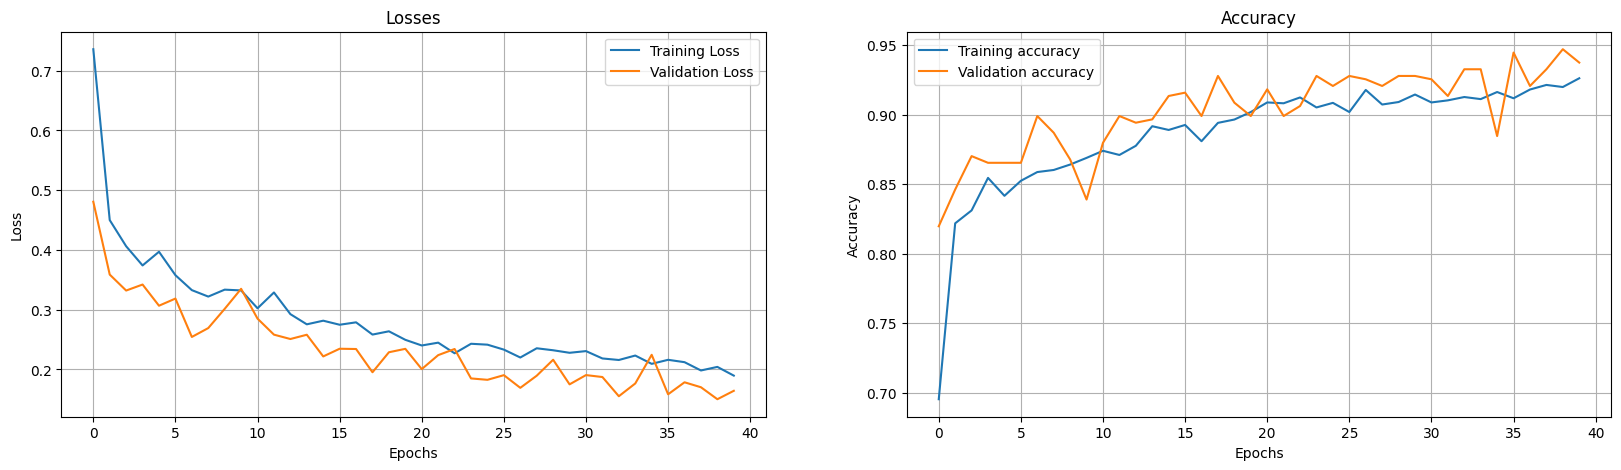

In [ ]:
# Plotting the training history
his_data = pd.DataFrame(history.history)
plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
plt.plot(his_data.loss, label="Training Loss")
plt.plot(his_data.val_loss, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Losses")
plt.grid()
plt.legend()

plt.subplot(1,2,2)
plt.plot(his_data.accuracy, label="Training accuracy")
plt.plot(his_data.val_accuracy, label="Validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy")
plt.grid()
plt.legend()

#### Prediction

First Image to Predict :

Actual label: Blight
1/1 [==============================] - 0s 212ms/step

Predicted label Blight


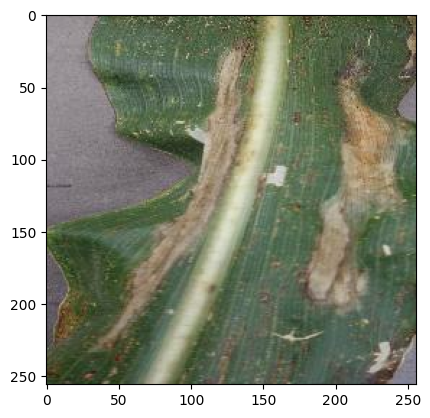

In [ ]:
for images_batch, labels_batch in test_ds.take(1):
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    print("First Image to Predict :")
    plt.imshow(first_image)
    print("\nActual label:",class_names[first_label])
    batch_prediction = model. predict (images_batch)
    print("\nPredicted label" ,class_names[np.argmax(batch_prediction[0])])

In [ ]:
# Define function to predict class and confidence score of a single image
def predict(model,img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) # Create a batch
    predictions = model.predict (img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
#   confidence = round(np.max(predictions[0]),2)
    confidence = round(100*(np.max(predictions[0])),2)

    return predicted_class, confidence

1/1 [==============================] - 0s 20ms/step


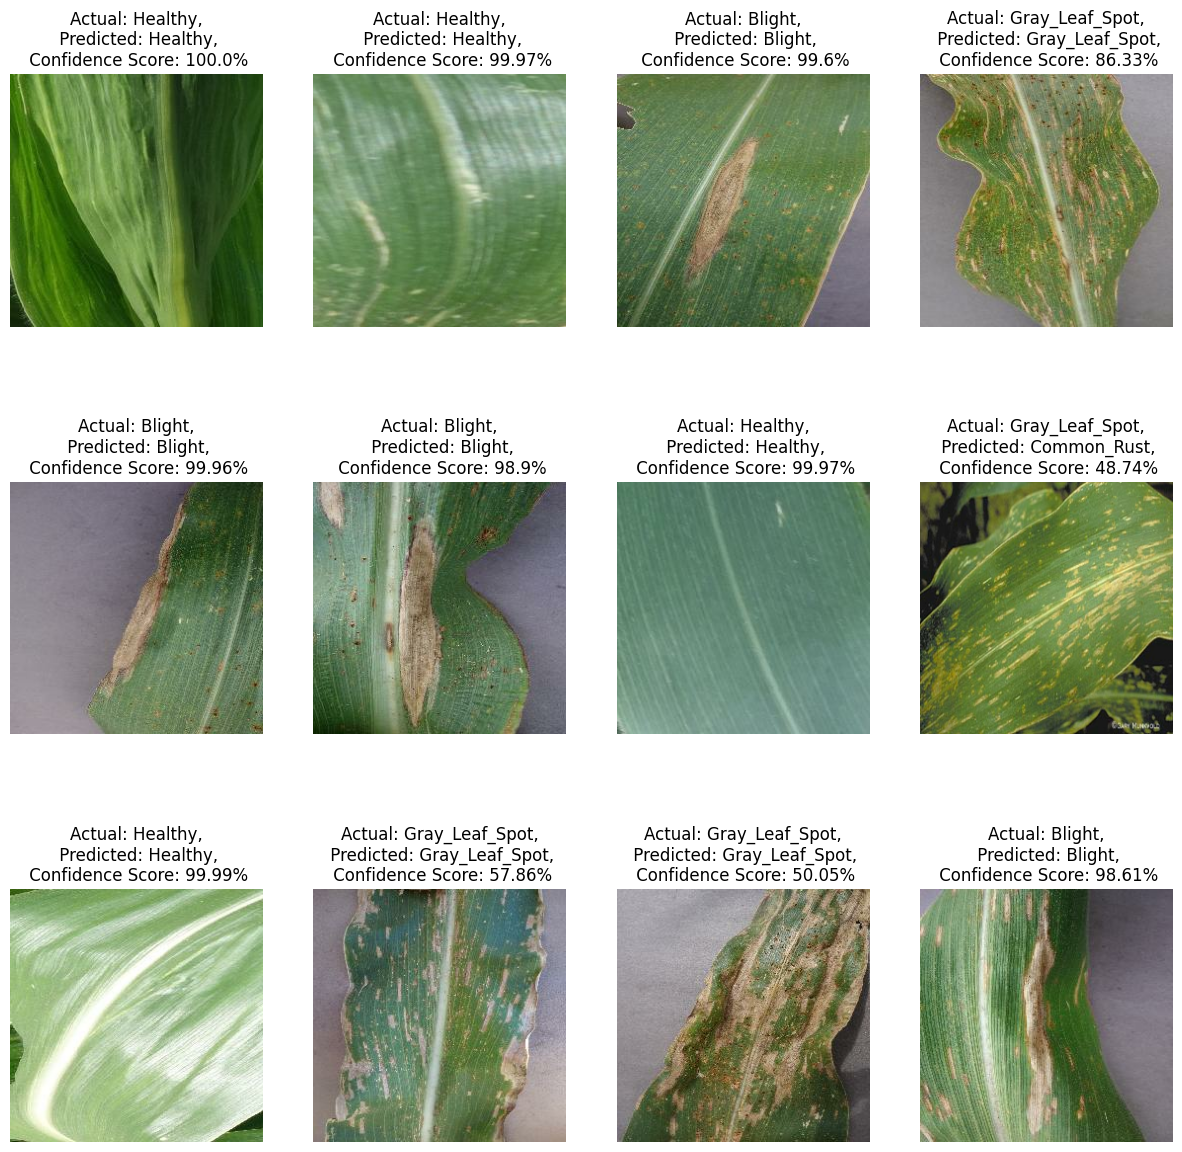

In [ ]:
# Display predictions for a batch of images
plt.figure(figsize=(15,15))
for images,labels in test_ds.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class , confidence = predict(model,images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class},\n Confidence Score: {confidence}%")
        plt.axis("off")

#### Save Model

In [ ]:
# Save the model
from keras.models import save_model
model.save('/content/drive/MyDrive/model/corn-maize-disease-model1.h5')